# Handling Imbalanced Data in Machine Learning

This notebook provides a comprehensive guide to understanding and handling imbalanced datasets in machine learning. We will explore various techniques, including oversampling, undersampling, and advanced methods like SMOTE and ensemble learning.

## 1. Introduction to Imbalanced Data

An imbalanced dataset is a dataset where the number of observations per class is not equally distributed. This is a common problem in many real-world scenarios such as fraud detection, medical diagnosis, and spam filtering. When one class (the majority class) significantly outnumbers another class (the minority class), machine learning models can become biased towards the majority class, leading to poor performance on the minority class, which is often the class of interest.

### 1.1 Why is it a problem?

Most standard machine learning algorithms assume that the class distribution is balanced. When this assumption is violated, the model may achieve high accuracy by simply predicting the majority class for all instances, while completely ignoring the minority class. This is problematic because in many applications, correctly identifying the minority class is crucial (e.g., detecting a rare disease or a fraudulent transaction).

### 1.2 Overview of Techniques

There are several techniques to handle imbalanced data, which can be broadly categorized into:

*   **Data-level methods:** These techniques modify the training data to create a balanced class distribution. This includes oversampling the minority class, undersampling the majority class, or a combination of both.
*   **Algorithm-level methods:** These techniques modify the learning algorithm to be more sensitive to the minority class. This often involves assigning different weights to the classes or using cost-sensitive learning.
*   **Ensemble methods:** These techniques combine multiple models to improve performance. Specialized ensemble methods have been developed for imbalanced learning.

## 2. Setup and Dataset Creation

In [ ]:
!uv pip install imbalanced-learn

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from collections import Counter

# Set plotting style
sns.set_style('whitegrid')

### 2.1 Create a Synthetic Imbalanced Dataset

Original dataset shape (1000, 10)
Original dataset samples per class Counter({np.int64(0): 950, np.int64(1): 50})


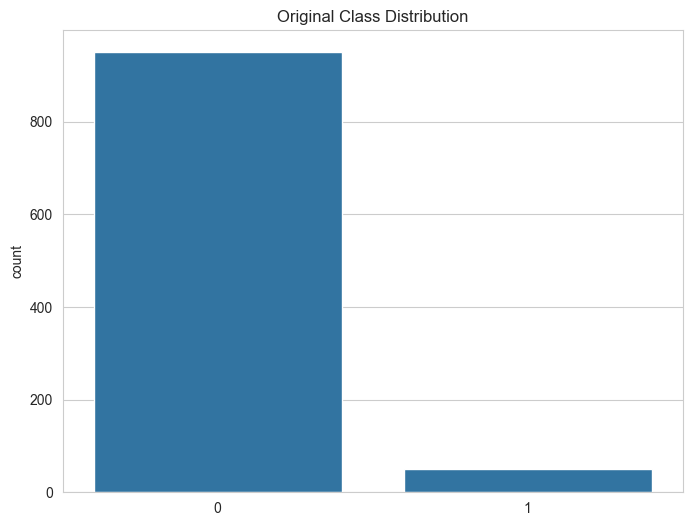

In [2]:
# Create a synthetic imbalanced dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=0,
                           n_classes=2, n_clusters_per_class=1, weights=[0.95, 0.05],
                           flip_y=0, random_state=42)

# Visualize the class distribution
counter = Counter(y)
print(f'Original dataset shape {X.shape}')
print(f'Original dataset samples per class {counter}')

plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Original Class Distribution')
plt.show()

## 3. Evaluation Metrics for Imbalanced Data

As discussed earlier, accuracy is not a suitable metric for evaluating models trained on imbalanced data. Instead, we should use metrics that provide a better picture of the model's performance on the minority class. Some of these metrics are:

*   **Confusion Matrix:** A table that summarizes the performance of a classification model.
*   **Precision:** The ratio of correctly predicted positive observations to the total predicted positive observations. `Precision = TP / (TP + FP)`
*   **Recall (Sensitivity):** The ratio of correctly predicted positive observations to all observations in the actual class. `Recall = TP / (TP + FN)`
*   **F1-Score:** The harmonic mean of precision and recall. `F1 Score = 2 * (Recall * Precision) / (Recall + Precision)`
*   **ROC-AUC:** The Area Under the Receiver Operating Characteristic Curve. It measures the ability of a classifier to distinguish between classes.

### 3.1 Helper Function for Evaluation

In [3]:
def evaluate_model(X_test, y_test, model):
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Predict classes
    y_pred = model.predict(X_test)
    
    # Print classification report
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
    # Print ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f'ROC-AUC Score: {roc_auc:.4f}')
    
    # Plotting Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

## 4. Baseline Model

Let's first train a simple Logistic Regression model on the original, imbalanced dataset. This will serve as our baseline to see how the different data handling techniques improve the model's performance.

--- Baseline Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       285
           1       1.00      0.40      0.57        15

    accuracy                           0.97       300
   macro avg       0.98      0.70      0.78       300
weighted avg       0.97      0.97      0.96       300

ROC-AUC Score: 0.9811


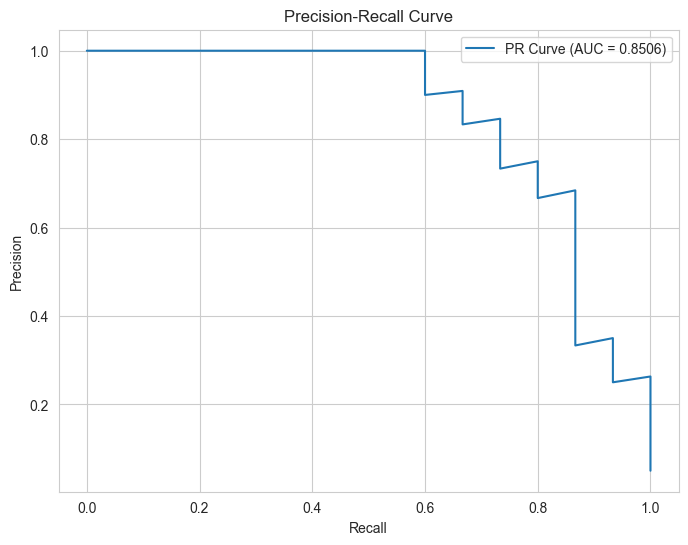

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a baseline logistic regression model
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)

# Evaluate the baseline model
print('--- Baseline Model Evaluation ---')
evaluate_model(X_test, y_test, baseline_model)

## 5. Oversampling Techniques

Oversampling techniques increase the number of instances in the minority class to balance the dataset. Let's explore some popular oversampling methods.

### 5.1 Random Oversampling

**What is Random Oversampling?**
Random oversampling is the simplest oversampling technique that works by randomly duplicating existing minority class samples until the classes are balanced. While straightforward to implement, this approach can lead to overfitting since it creates exact copies of existing data points without adding new information to help the model generalize better.

**When to use:** Good starting point for oversampling, works well when you have sufficient diverse minority samples, and computational resources are limited.

Resampled dataset shape (1330, 10)
Resampled dataset samples per class Counter({np.int64(0): 665, np.int64(1): 665})
--- Random Oversampling Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       285
           1       0.92      0.73      0.81        15

    accuracy                           0.98       300
   macro avg       0.95      0.86      0.90       300
weighted avg       0.98      0.98      0.98       300

ROC-AUC Score: 0.9899


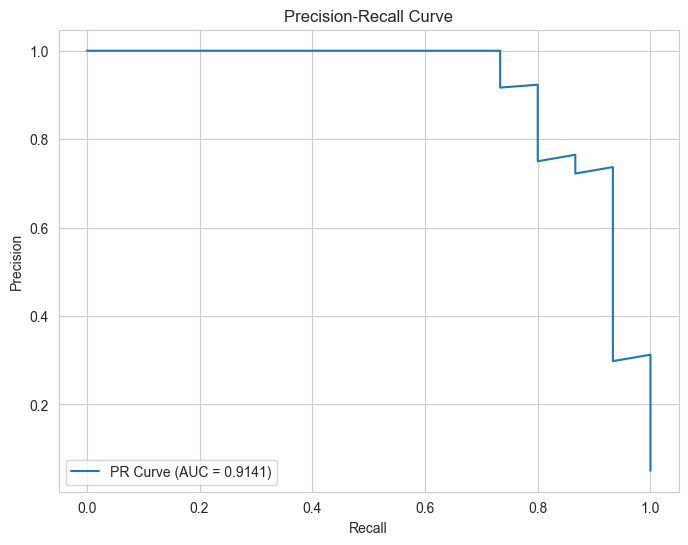

In [5]:
# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Visualize the class distribution
print(f'Resampled dataset shape {X_ros.shape}')
print(f'Resampled dataset samples per class {Counter(y_ros)}')

# Train a logistic regression model on the resampled data
ros_model = LogisticRegression(random_state=42)
ros_model.fit(X_ros, y_ros)

# Evaluate the model
print('--- Random Oversampling Model Evaluation ---')
evaluate_model(X_test, y_test, ros_model)

### 5.2 SMOTE (Synthetic Minority Oversampling Technique)

**What is SMOTE?**
SMOTE (Synthetic Minority Oversampling Technique) generates synthetic minority class samples by creating new instances along the line segments connecting minority class samples to their k-nearest minority neighbors. This approach creates more diverse data points compared to simple duplication, potentially helping the model learn better decision boundaries.

**When to use:** Preferred over random oversampling when you want to avoid exact duplication, works well with continuous features, and is effective when minority samples have meaningful relationships in the feature space.

Resampled dataset shape (1330, 10)
Resampled dataset samples per class Counter({np.int64(0): 665, np.int64(1): 665})
--- SMOTE Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       285
           1       0.91      0.67      0.77        15

    accuracy                           0.98       300
   macro avg       0.95      0.83      0.88       300
weighted avg       0.98      0.98      0.98       300

ROC-AUC Score: 0.9862


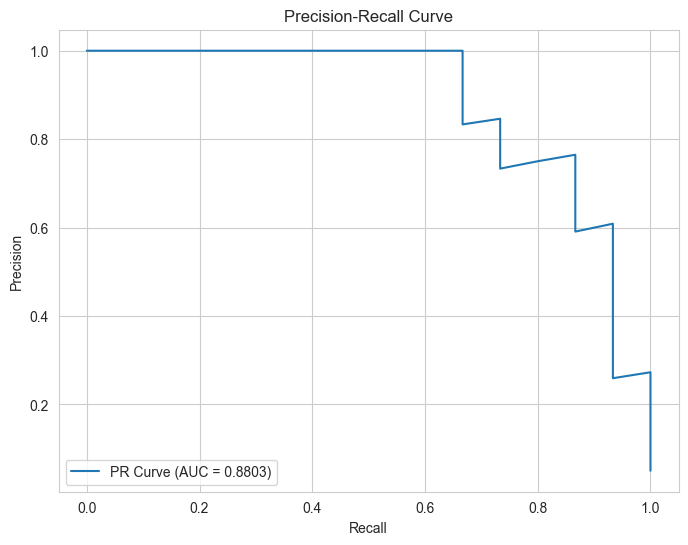

In [6]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Visualize the class distribution
print(f'Resampled dataset shape {X_smote.shape}')
print(f'Resampled dataset samples per class {Counter(y_smote)}')

# Train a logistic regression model on the resampled data
smote_model = LogisticRegression(random_state=42)
smote_model.fit(X_smote, y_smote)

# Evaluate the model
print('--- SMOTE Model Evaluation ---')
evaluate_model(X_test, y_test, smote_model)

### 5.3 Borderline SMOTE

**What is Borderline SMOTE?**
Borderline SMOTE is an enhanced version of SMOTE that focuses on generating synthetic samples from minority class instances that are "difficult to learn" - those near the decision boundary between classes. It identifies borderline minority samples (those with mostly majority class neighbors) and creates new synthetic samples specifically from these challenging cases, potentially improving classification performance near class boundaries.

**When to use:** When you have clear class separation issues, when standard SMOTE doesn't perform well, and when you want to focus synthetic generation on the most challenging minority samples.

Resampled dataset shape (1330, 10)
Resampled dataset samples per class Counter({np.int64(0): 665, np.int64(1): 665})
--- Borderline SMOTE Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       285
           1       0.85      0.73      0.79        15

    accuracy                           0.98       300
   macro avg       0.92      0.86      0.89       300
weighted avg       0.98      0.98      0.98       300

ROC-AUC Score: 0.9885


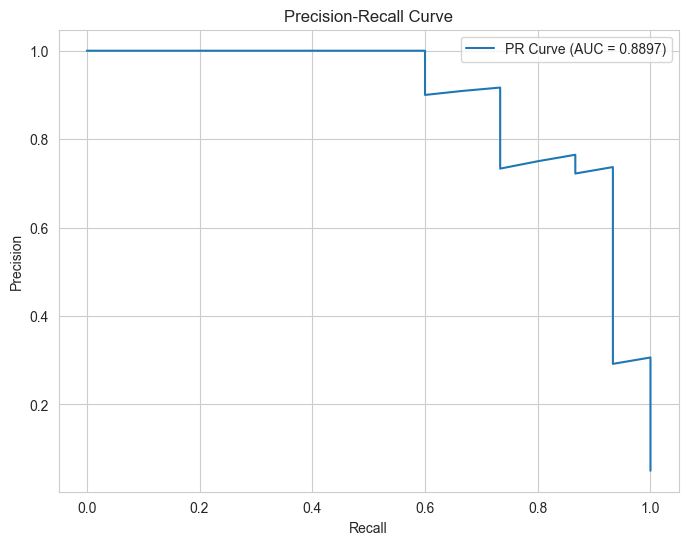

In [7]:
# Apply Borderline SMOTE
bsmote = BorderlineSMOTE(random_state=42)
X_bsmote, y_bsmote = bsmote.fit_resample(X_train, y_train)

# Visualize the class distribution
print(f'Resampled dataset shape {X_bsmote.shape}')
print(f'Resampled dataset samples per class {Counter(y_bsmote)}')

# Train a logistic regression model on the resampled data
bsmote_model = LogisticRegression(random_state=42)
bsmote_model.fit(X_bsmote, y_bsmote)

# Evaluate the model
print('--- Borderline SMOTE Model Evaluation ---')
evaluate_model(X_test, y_test, bsmote_model)

### 5.4 ADASYN (Adaptive Synthetic Sampling)

**What is ADASYN?**
ADASYN (Adaptive Synthetic Sampling) is an adaptive oversampling method that generates different numbers of synthetic samples for each minority class instance based on how difficult it is to learn. Minority samples in denser majority regions get more synthetic samples generated, while those in safer minority regions get fewer. This density-based approach aims to improve learning of the overall class distribution.

**When to use:** When you have varying local density patterns in your data, when some minority samples are much harder to classify than others, and when you want an adaptive approach that adjusts generation based on local neighborhoods.

Resampled dataset shape (1327, 10)
Resampled dataset samples per class Counter({np.int64(0): 665, np.int64(1): 662})
--- ADASYN Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       285
           1       0.93      0.87      0.90        15

    accuracy                           0.99       300
   macro avg       0.96      0.93      0.95       300
weighted avg       0.99      0.99      0.99       300

ROC-AUC Score: 0.9937


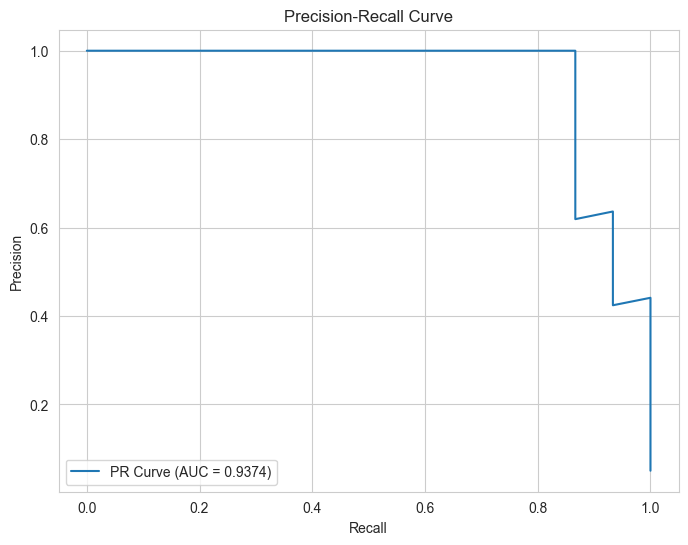

In [8]:
# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

# Visualize the class distribution
print(f'Resampled dataset shape {X_adasyn.shape}')
print(f'Resampled dataset samples per class {Counter(y_adasyn)}')

# Train a logistic regression model on the resampled data
adasyn_model = LogisticRegression(random_state=42)
adasyn_model.fit(X_adasyn, y_adasyn)

# Evaluate the model
print('--- ADASYN Model Evaluation ---')
evaluate_model(X_test, y_test, adasyn_model)

## 6. Undersampling Techniques

Undersampling techniques reduce the number of instances in the majority class to balance the dataset. This can be useful when the dataset is very large and training time is a concern. However, it can also lead to loss of important information.

### 6.1 Random Undersampling

**What is Random Undersampling?**
Random undersampling reduces the majority class size by randomly removing samples until balance is achieved. This is the fastest undersampling approach and reduces computational costs, but it risks losing potentially important information from the discarded majority samples, which could hurt model performance.

**When to use:** When you have a very large dataset with abundant majority samples, when computational resources or training time are major constraints, and when the majority class has many redundant or similar samples.

Resampled dataset shape (70, 10)
Resampled dataset samples per class Counter({np.int64(0): 35, np.int64(1): 35})
--- Random Undersampling Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       285
           1       0.61      0.73      0.67        15

    accuracy                           0.96       300
   macro avg       0.80      0.85      0.82       300
weighted avg       0.97      0.96      0.96       300

ROC-AUC Score: 0.9677


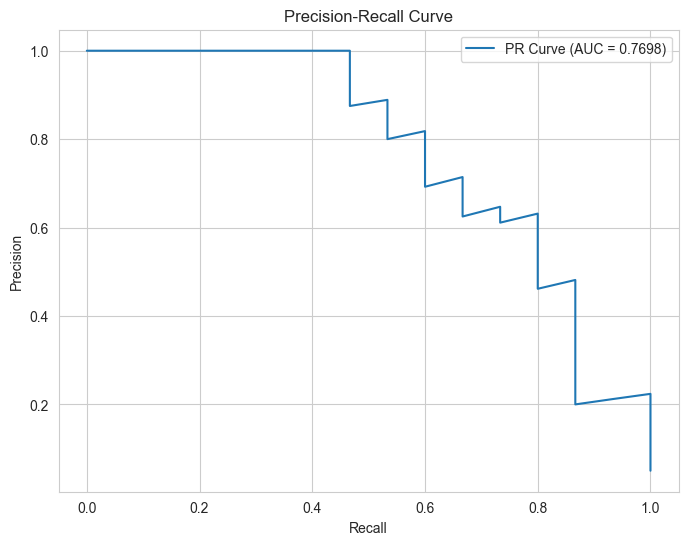

In [9]:
# Apply Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Visualize the class distribution
print(f'Resampled dataset shape {X_rus.shape}')
print(f'Resampled dataset samples per class {Counter(y_rus)}')

# Train a logistic regression model on the resampled data
rus_model = LogisticRegression(random_state=42)
rus_model.fit(X_rus, y_rus)

# Evaluate the model
print('--- Random Undersampling Model Evaluation ---')
evaluate_model(X_test, y_test, rus_model)

### 6.2 Tomek Links

**What are Tomek Links?**
Tomek Links identify pairs of samples from different classes that are each other's nearest neighbors. This technique removes majority class samples that form Tomek Links with minority samples, effectively cleaning up the decision boundary by removing ambiguous or noisy majority samples that are too close to minority samples. Note that this method typically removes relatively few samples and may not achieve full balance.

**When to use:** When you want to clean noisy boundaries rather than achieve perfect balance, as a preprocessing step before other techniques, and when you have overlapping classes with unclear boundaries.

Resampled dataset shape (700, 10)
Resampled dataset samples per class Counter({np.int64(0): 665, np.int64(1): 35})
--- Tomek Links Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       285
           1       1.00      0.40      0.57        15

    accuracy                           0.97       300
   macro avg       0.98      0.70      0.78       300
weighted avg       0.97      0.97      0.96       300

ROC-AUC Score: 0.9811


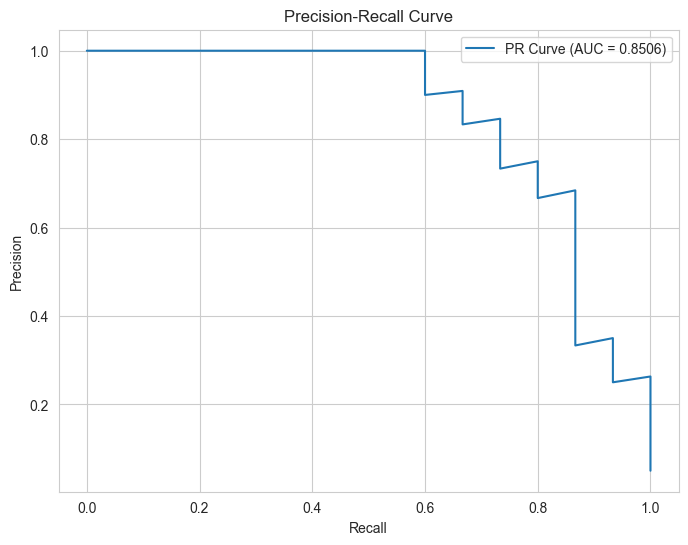

In [10]:
# Apply Tomek Links
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train, y_train)

# Visualize the class distribution
print(f'Resampled dataset shape {X_tl.shape}')
print(f'Resampled dataset samples per class {Counter(y_tl)}')

# Train a logistic regression model on the resampled data
tl_model = LogisticRegression(random_state=42)
tl_model.fit(X_tl, y_tl)

# Evaluate the model
print('--- Tomek Links Model Evaluation ---')
evaluate_model(X_test, y_test, tl_model)

### 6.3 NearMiss

**What is NearMiss?**
NearMiss is an intelligent undersampling technique that selects which majority class samples to keep based on their distance relationships with minority class samples. The goal is to retain the most informative majority samples while discarding those that don't contribute meaningfully to learning the decision boundary. Different NearMiss versions (1, 2, 3) use different distance criteria for selection.

**When to use:** When you want smarter undersampling than random selection, when majority samples vary significantly in their informativeness, and when you want to preserve majority samples that are most relevant for learning class boundaries.

Resampled dataset shape (70, 10)
Resampled dataset samples per class Counter({np.int64(0): 35, np.int64(1): 35})
--- NearMiss Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       285
           1       0.80      0.53      0.64        15

    accuracy                           0.97       300
   macro avg       0.89      0.76      0.81       300
weighted avg       0.97      0.97      0.97       300

ROC-AUC Score: 0.9450


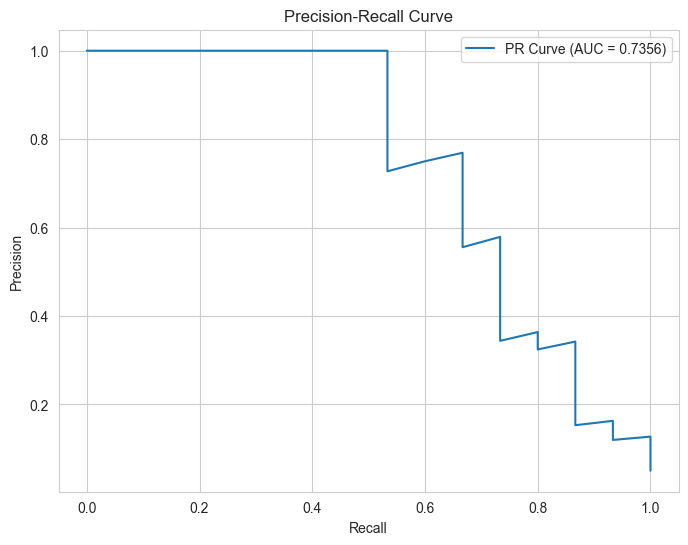

In [11]:
# Apply NearMiss
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X_train, y_train)

# Visualize the class distribution
print(f'Resampled dataset shape {X_nm.shape}')
print(f'Resampled dataset samples per class {Counter(y_nm)}')

# Train a logistic regression model on the resampled data
nm_model = LogisticRegression(random_state=42)
nm_model.fit(X_nm, y_nm)

# Evaluate the model
print('--- NearMiss Model Evaluation ---')
evaluate_model(X_test, y_test, nm_model)

## 7. Combination Techniques

Combination techniques, also known as hybrid methods, combine oversampling and undersampling techniques to achieve a better-balanced dataset. These methods can often provide better results than using either oversampling or undersampling alone.

### 7.1 SMOTE + Tomek Links

**What is SMOTE + Tomek Links?**
This hybrid approach combines the best of both worlds: first SMOTE generates synthetic minority samples to increase their representation, then Tomek Links cleans up the decision boundary by removing majority samples that are too close to (potentially synthetic) minority samples. This two-step process both balances the dataset and reduces noise around class boundaries.

**When to use:** When you want both class balance and clean decision boundaries, when you have noisy data with overlapping classes, and when neither pure oversampling nor undersampling alone gives satisfactory results.

Resampled dataset shape (1330, 10)
Resampled dataset samples per class Counter({np.int64(0): 665, np.int64(1): 665})
--- SMOTE + Tomek Links Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       285
           1       0.91      0.67      0.77        15

    accuracy                           0.98       300
   macro avg       0.95      0.83      0.88       300
weighted avg       0.98      0.98      0.98       300

ROC-AUC Score: 0.9862


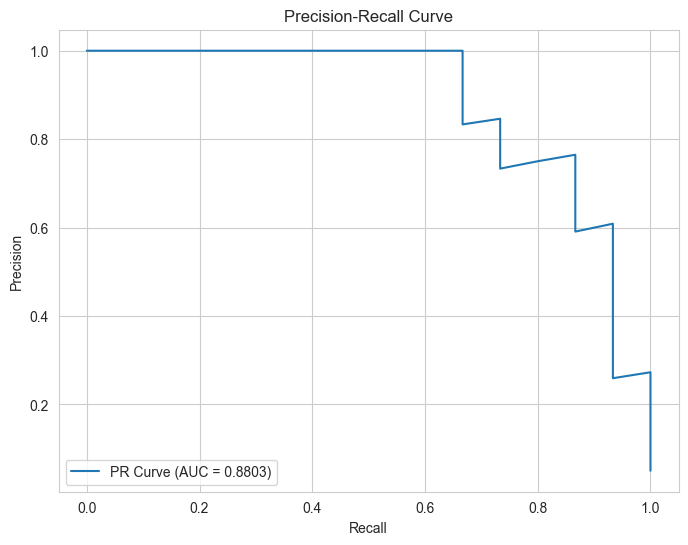

In [12]:
# Apply SMOTE + Tomek Links
smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X_train, y_train)

# Visualize the class distribution
print(f'Resampled dataset shape {X_smt.shape}')
print(f'Resampled dataset samples per class {Counter(y_smt)}')

# Train a logistic regression model on the resampled data
smt_model = LogisticRegression(random_state=42)
smt_model.fit(X_smt, y_smt)

# Evaluate the model
print('--- SMOTE + Tomek Links Model Evaluation ---')
evaluate_model(X_test, y_test, smt_model)

### 7.2 SMOTE + ENN (Edited Nearest Neighbors)

**What is SMOTE + ENN?**
Similar to SMOTE + Tomek Links, this method first applies SMOTE for oversampling, then uses Edited Nearest Neighbors (ENN) for cleaning. ENN removes samples whose class labels differ from the majority of their k-nearest neighbors, effectively removing mislabeled or ambiguous samples from both classes. This tends to be more aggressive in cleaning than Tomek Links.

**When to use:** When you suspect mislabeled data or very noisy samples, when you want more aggressive boundary cleaning than Tomek Links provides, and when you have samples that don't fit well with their supposed class neighbors.

Resampled dataset shape (1325, 10)
Resampled dataset samples per class Counter({np.int64(1): 665, np.int64(0): 660})
--- SMOTE + ENN Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       285
           1       0.85      0.73      0.79        15

    accuracy                           0.98       300
   macro avg       0.92      0.86      0.89       300
weighted avg       0.98      0.98      0.98       300

ROC-AUC Score: 0.9864


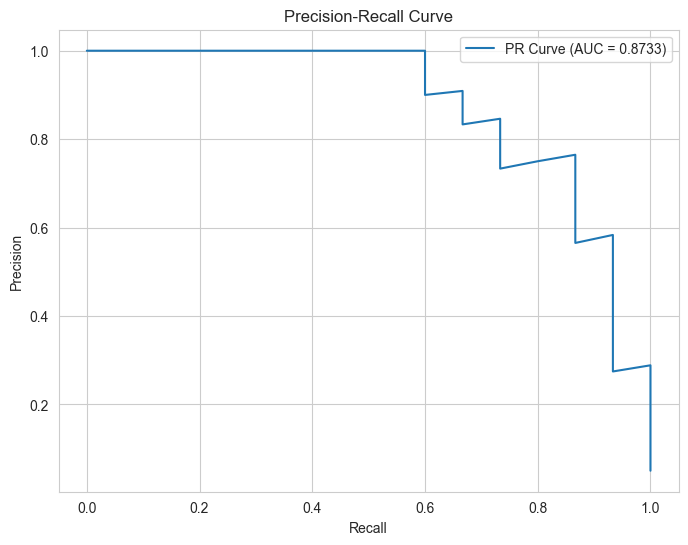

In [13]:
# Apply SMOTE + ENN
sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(X_train, y_train)

# Visualize the class distribution
print(f'Resampled dataset shape {X_sme.shape}')
print(f'Resampled dataset samples per class {Counter(y_sme)}')

# Train a logistic regression model on the resampled data
sme_model = LogisticRegression(random_state=42)
sme_model.fit(X_sme, y_sme)

# Evaluate the model
print('--- SMOTE + ENN Model Evaluation ---')
evaluate_model(X_test, y_test, sme_model)

## 8. Ensemble Methods

Ensemble methods combine the predictions of several base estimators to improve the overall performance. Some ensemble methods are specifically designed to handle imbalanced datasets.

### 8.1 BalancedRandomForestClassifier

**What is Balanced Random Forest?**
This ensemble method modifies the traditional Random Forest by ensuring each tree in the forest is trained on a balanced bootstrap sample. It randomly undersamples the majority class for each tree, creating diverse balanced training sets. The final prediction combines all trees' votes, leveraging ensemble strength while addressing imbalance at the individual tree level.

**When to use:** When Random Forest is your preferred algorithm, when you want an ensemble approach without manual resampling, and when you have enough data that undersampling for each tree won't lose critical information.

--- BalancedRandomForestClassifier Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       285
           1       0.59      0.67      0.62        15

    accuracy                           0.96       300
   macro avg       0.79      0.82      0.80       300
weighted avg       0.96      0.96      0.96       300

ROC-AUC Score: 0.9421


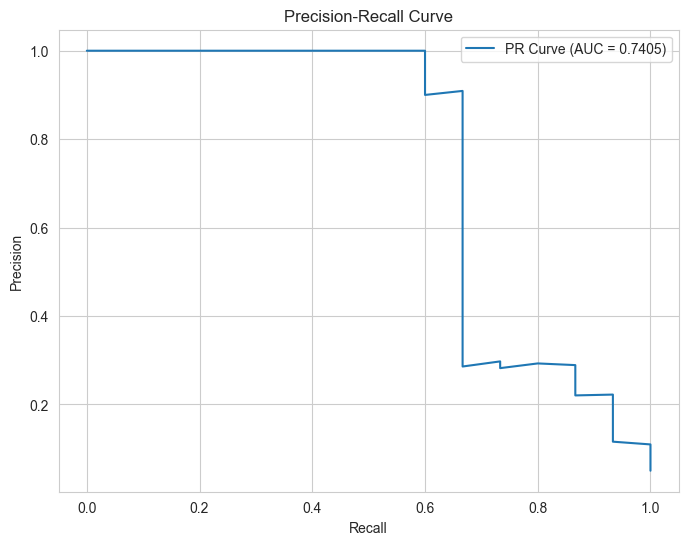

In [14]:
# Apply BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(random_state=42)
brf.fit(X_train, y_train)

# Evaluate the model
print('--- BalancedRandomForestClassifier Model Evaluation ---')
evaluate_model(X_test, y_test, brf)

### 8.2 BalancedBaggingClassifier

**What is Balanced Bagging?**
Balanced Bagging modifies the traditional bagging ensemble method by ensuring each base classifier is trained on a balanced bootstrap sample. For each estimator in the ensemble, it creates a balanced training set through resampling (typically undersampling the majority class), then trains the base classifier on this balanced data. The diverse balanced perspectives are combined for final predictions.

**When to use:** When you want to use bagging with any base classifier (not just trees), when you prefer ensemble methods over single models, and when you want automatic balancing integrated into the ensemble process.

--- BalancedBaggingClassifier Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       285
           1       0.38      0.67      0.49        15

    accuracy                           0.93       300
   macro avg       0.68      0.81      0.73       300
weighted avg       0.95      0.93      0.94       300

ROC-AUC Score: 0.9270


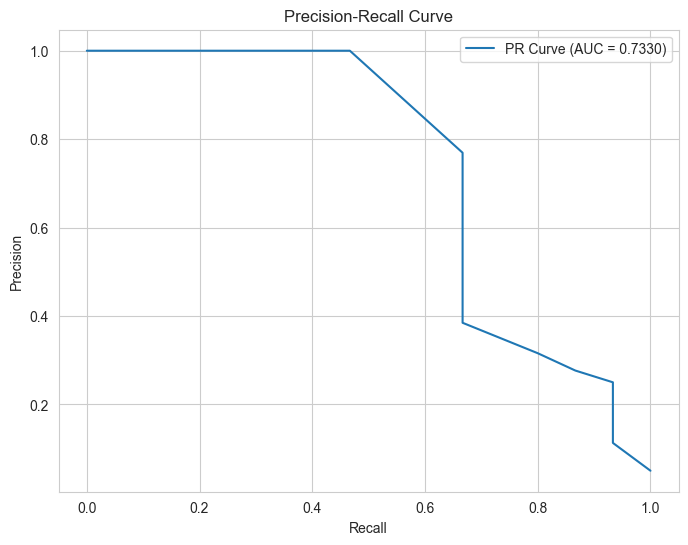

In [15]:
# Apply BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(X_train, y_train)

# Evaluate the model
print('--- BalancedBaggingClassifier Model Evaluation ---')
evaluate_model(X_test, y_test, bbc)

### 8.3 EasyEnsembleClassifier

**What is Easy Ensemble?**
Easy Ensemble creates multiple balanced training sets by independently undersampling the majority class multiple times, then trains a separate classifier on each balanced subset. Unlike bagging which uses sampling with replacement, Easy Ensemble uses sampling without replacement to create non-overlapping majority class subsets. This ensures all majority class samples are used while creating multiple balanced training perspectives.

**When to use:** When you have a very large majority class that can be split into multiple meaningful subsets, when you want to use all your majority class data without losing information, and when you prefer undersampling-based ensemble approaches.

--- EasyEnsembleClassifier Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       285
           1       0.39      0.80      0.52        15

    accuracy                           0.93       300
   macro avg       0.69      0.87      0.74       300
weighted avg       0.96      0.93      0.94       300

ROC-AUC Score: 0.9357


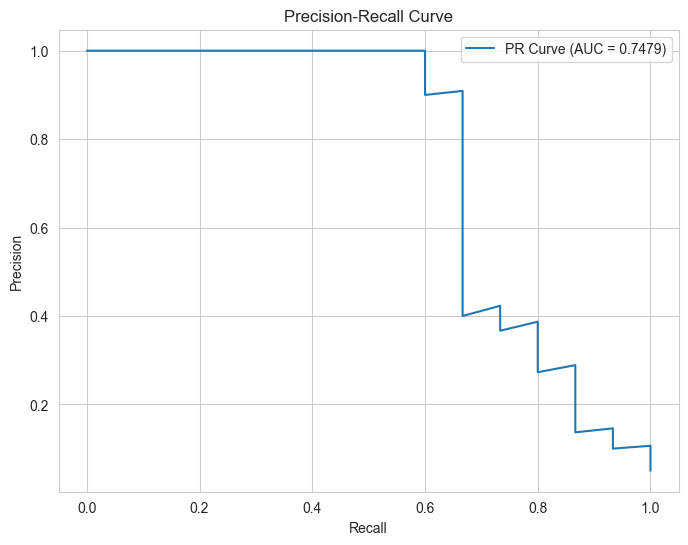

In [16]:
# Apply EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=42)
eec.fit(X_train, y_train)

# Evaluate the model
print('--- EasyEnsembleClassifier Model Evaluation ---')
evaluate_model(X_test, y_test, eec)

## 9. Final Comparison

After applying various techniques, we can compare their performance to see which one worked best for our synthetic dataset. The choice of the best technique will depend on the specific dataset and the problem at hand.

## 10. Practical Tips and Best Practices

Here are some practical tips and best practices for handling imbalanced data:

*   **Choose the right evaluation metric:** As we've seen, accuracy is not a good metric for imbalanced datasets. Use metrics like Precision, Recall, F1-score, and ROC-AUC.
*   **Don't test on the resampled data:** Always resample only the training data and test your model on the original, untouched test set. This prevents data leakage and gives a more realistic estimate of the model's performance on unseen data.
*   **Cross-validation:** Use stratified cross-validation to ensure that the class distribution in each fold is representative of the original dataset.
*   **Consider class weights:** Many machine learning algorithms have a `class_weight` parameter that can be set to `balanced` to automatically adjust for class imbalance. This is a simple and often effective technique.
*   **Experiment with different techniques:** There is no one-size-fits-all solution for imbalanced data. It's important to experiment with different techniques to find the one that works best for your specific problem.